In [88]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [89]:
# Get working directory 
cwd = os.getcwd()
# Set random seed for reproducibility
np.random.seed(0)

This project attempts to predict the probability that the next MLB pitch will be a fastball/curveball/slider/etc. I am using a dataset of 718961 pitches from the 2011 MLB season. I will use following steps to answer this question:

(1) Data Exploration

(2) Data Cleaning

(3) Feature Engineering

(4) Model Selection

(5) Model Training & Evaluation

(6) Results Discussion and Areas for Improvement

# Data Exploration

Load "pitches" file into pandas dataframe, review dataframe to ensure data is loaded correctly. Review data at column level to identify columns with missing values, data entry errors, or little to no predictive value (noisy/not relevant to pitch selection).

In [90]:
# Read data into pandas dataframe
pitch_raw = pd.read_csv(cwd + '\pitches_folder_(1)\pitches_folder\pitches', low_memory=False)
print('pitches dataset shape:', pitch_raw.shape)

pitches dataset shape: (718961, 125)


In [91]:
# Review dataframe (first 5 rows)
pitch_raw.head()

,uid,game_pk,year,date,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,...,runner7_start,runner7_end,runner7_event,runner7_score,runner7_rbi,runner7_earned,created_at,added_at,modified_at,modified_by
0,14143226,286874,2011,2011-03-31,108,118,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
1,14143227,286874,2011,2011-03-31,108,118,1,1,1,2,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
2,14143228,286874,2011,2011-03-31,108,118,1,1,1,3,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
3,14143229,286874,2011,2011-03-31,108,118,1,1,1,4,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1
4,14143230,286874,2011,2011-03-31,108,118,1,1,2,1,...,NaN,NaN,NaN,NaN,NaN,NaN,2016-03-03 21:33:20,2016-03-03 21:33:20,2016-03-03 21:33:20,1


In [92]:
# Review summary statistics by column (select specific column using loc w/ column name)
pitch_raw.loc[:, :].describe()

,uid,game_pk,year,team_id_b,team_id_p,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,...,runner6_rbi,runner6_earned,runner7_id,runner7_start,runner7_end,runner7_event,runner7_score,runner7_rbi,runner7_earned,modified_by
count,7.189610e+05,718961.000000,718961.0,718961.000000,718961.000000,718961.000000,718961.000000,718961.000000,718961.000000,718961.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,718961.0
mean,1.701980e+07,288557.611823,2011.0,128.787182,128.757296,5.033796,0.508900,39.301513,2.865276,37.357196,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
std,1.665143e+06,3642.210956,0.0,14.281039,14.306711,2.692326,0.499921,23.320725,1.715068,30.690569,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
min,1.414323e+07,286874.000000,2011.0,108.000000,108.000000,1.000000,0.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
25%,1.557356e+07,287507.000000,2011.0,115.000000,115.000000,3.000000,0.000000,19.000000,1.000000,11.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
50%,1.703106e+07,288129.000000,2011.0,134.000000,134.000000,5.000000,1.000000,39.000000,3.000000,28.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
75%,1.845894e+07,288749.000000,2011.0,141.000000,141.000000,7.000000,1.000000,58.000000,4.000000,61.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
max,1.983820e+07,317073.000000,2011.0,158.000000,158.000000,19.000000,1.000000,158.000000,16.000000,133.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


When building the predictive model, available_prior_to_pitch == NO features like is_final_pitch, final_strikes, final_balls won't be included as these lead to data leaks (making predictions based on extra information not available in real world scenarios). I will focus on including relevant features where available_prior_to_pitch == YES and creating additional features via the supplied dataset instead. Of the included features where available_prior_to_pitch == YES, inning, top, at_bat_num, pcount_at_bat, pcount_pitcher, balls, strikes, fouls, outs, away_team_runs, home_team_runs are features that are both available at time of pitch and seem like relevant features a pitcher/catcher may consider when selecting the next pitch.

Note: Categorical features like stand, b_height, p_throws, on_1b, on_2b, on_3b are relevant but require some modification/encoding before they can be used in the model. 

Note: Other categorical features like pitcher_id, batter_id will require in depth feature engineering to account for each pitcher's/hitter's unique traits. I will attempt to address some of these through feature engineering.

Note: There is a data entry error in the "balls" column (the max should be 3 and not 4). I will correct this in the data cleaning step.

In [93]:
# Identify features with null values
for entry in pitch_raw.columns:
    if pitch_raw[entry].isna().any():
        print('Missing values for ' + entry + ':', pitch_raw[entry].isna().sum())

Missing values for event2: 710662
Missing values for event3: 718627
Missing values for event4: 718938
Missing values for score: 662865
Missing values for pitch_tfs: 302
Missing values for pitch_tfs_zulu: 302
Missing values for sv_id: 2280
Missing values for start_speed: 2280
Missing values for end_speed: 2280
Missing values for sz_top: 2280
Missing values for sz_bot: 2280
Missing values for pfx_x: 2280
Missing values for pfx_z: 2280
Missing values for px: 2280
Missing values for pz: 2280
Missing values for x0: 2280
Missing values for z0: 2280
Missing values for y0: 2280
Missing values for vx0: 2280
Missing values for vz0: 2280
Missing values for vy0: 2280
Missing values for ax: 2280
Missing values for az: 2280
Missing values for ay: 2280
Missing values for break_length: 2280
Missing values for break_y: 2280
Missing values for break_angle: 2280
Missing values for pitch_type: 2280
Missing values for type_confidence: 2280
Missing values for zone: 2280
Missing values for nasty: 2280
Missin

Some of these features have intentional nulls (i.e, on_1b/on_2b/on_3b is null every time a runner is not on base). Other features have nulls due to data gathering/recording errors. For example, the pitchf/x based features are missing 2280 records which, from a brief investigation of the data, seem to be due to errors in the system's data recording ability. In the code block below I highlight how the ptichf/x system fails to capture 2 pitches in the same at bat even though the first pitch was successfully recorded by the system. This temporary lapse in coverage supports the idea that pitchf/x experienced a momentary outage.

In [94]:
pitch_raw.iloc[717946:717949][['batter_id', 'pcount_at_bat', 'pitch_type', 'type_confidence', 'sv_id', 'event', 'pitch_des']]

,batter_id,pcount_at_bat,pitch_type,type_confidence,sv_id,event,pitch_des
717946,461815,1,SI,0.0,111023_215019,Groundout,Ball
717947,461815,2,NaN,NaN,NaN,Groundout,Called Strike
717948,461815,3,NaN,NaN,NaN,Groundout,"In play, out(s)"


array([[<AxesSubplot:title={'center':'pcount_at_bat'}>]], dtype=object)

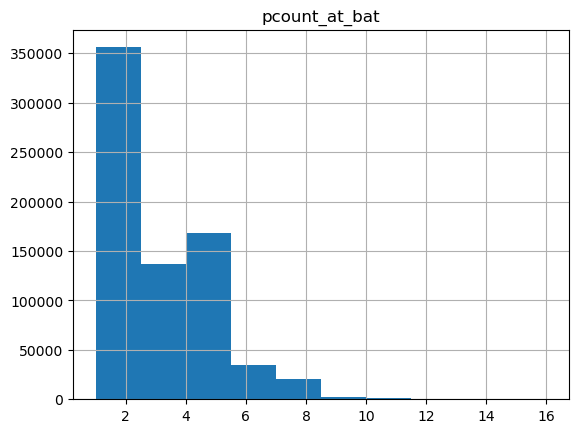

In [95]:
# Display distribution of target features (can be applied to other cols by modifying string below)
pitch_raw.hist(column='pcount_at_bat')

After investigating distributions of each feature I found that most are right skewed (pcount_pitcher, balls, strikes, pcount_at_bat, inning). I do not plan on implementing a model that assumes features are normally distributed.

FF    238541
SL    109756
SI     87740
FT     81056
CH     72641
CU     56379
FC     41702
FS     10503
KC      8490
KN      4450
IN      4058
PO       559
FO       329
FA       204
EP       134
SC       120
UN        17
AB         2
Name: pitch_type, dtype: int64


<AxesSubplot:>

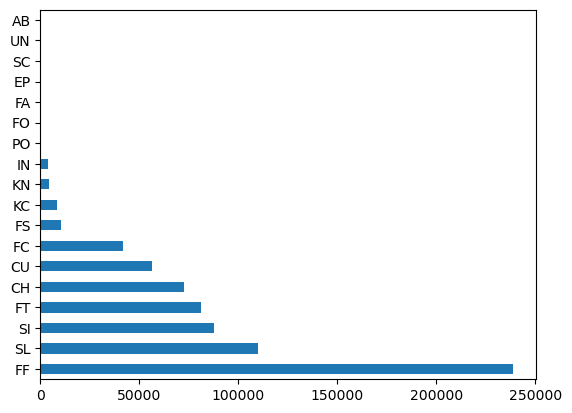

In [96]:
# Display counts of response variable - https://library.fangraphs.com/pitch-type-abbreviations-classifications/ (glossary)
print(pitch_raw['pitch_type'].value_counts())
pitch_raw['pitch_type'].value_counts().plot(kind='barh')

Quick check of the response variable ('pitch_type') indicates that in addition to "normal" pitches (FF, SL, SI) we also have some other types of pitches like intentional balls (IN), pitch outs (PO), automatic balls (AB), and unidentified pitches (UN).

In [97]:
# Plot correlation matrix for relevant continuous variables
pitch_raw[['inning', 'top', 'at_bat_num', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes', 'fouls', 'outs', 'away_team_runs', 'home_team_runs']].corr()

,inning,top,at_bat_num,pcount_at_bat,pcount_pitcher,balls,strikes,fouls,outs,away_team_runs,home_team_runs
inning,1.000000,0.040080,0.976345,0.001994,0.011408,0.000806,-0.001120,0.012528,0.006970,0.488920,0.479113
top,0.040080,1.000000,-0.052070,-0.001936,-0.003265,-0.006695,0.003789,0.001506,-0.000118,-0.038229,-0.015905
at_bat_num,0.976345,-0.052070,1.000000,0.002830,-0.010610,0.003149,-0.002155,0.012070,0.055935,0.582427,0.569699
pcount_at_bat,0.001994,-0.001936,0.002830,1.000000,0.037542,0.808324,0.788282,0.674100,0.008367,0.002494,0.003003
pcount_pitcher,0.011408,-0.003265,-0.010610,0.037542,1.000000,0.030773,0.027916,0.044571,0.088280,-0.082580,-0.059823
balls,0.000806,-0.006695,0.003149,0.808324,0.030773,1.000000,0.367367,0.306093,0.020036,0.001784,0.002551
strikes,-0.001120,0.003789,-0.002155,0.788282,0.027916,0.367367,1.000000,0.595372,-0.003767,0.000900,0.000013
fouls,0.012528,0.001506,0.012070,0.674100,0.044571,0.306093,0.595372,1.000000,-0.005467,0.005626,0.004347
outs,0.006970,-0.000118,0.055935,0.008367,0.088280,0.020036,-0.003767,-0.005467,1.000000,0.034085,0.031429
away_team_runs,0.488920,-0.038229,0.582427,0.002494,-0.082580,0.001784,0.000900,0.005626,0.034085,1.000000,0.274851


Some features have very high correlation coefficients (i.e., inning and at_bat_num), these may need to be handled through feature engineering/selection.

# Data Cleaning

There are multiple missing entries in the pitch_type column (possibly due to pitchf/x system recording outages), I will address these by:

(1) Converting pitch_type == "UN" rows to "IN" (after investigating pitch descriptions of unknown entries I found that nearly all were intentional balls)

(2) Removing pitch_type == "AB" rows (these are outliers where the pitcher did not deliver an official pitch to the batter)

(3) Removing 2280 null rows where pitchf/x data was missing. I considered imputing the missing response variable but given that the most common pitch only represents ~30% of all pitches thrown most rows would be misclassified with this approach. I tested model performance with and without imputation and removing null pitchf/x feature rows resulted in higher model performance.

I will correct 4 ball counts to 3 ball counts in the dataset (clear data entry errors)

In [98]:
# Convert 'UN' pitch_type values to 'IN'
pitch_clean = pitch_raw.copy()
pitch_clean.loc[pitch_clean.pitch_type == 'UN', 'pitch_type'] = 'IN'

# Remove 'AB pitch_type outlier values
pitch_clean = pitch_clean[pitch_clean.pitch_type != 'AB']

# Remove Null pitchf/x rows
pitch_clean = pitch_clean.dropna(subset=['pitch_type'])

# Correct balls == 4 features to balls == 3 (data entry error)
pitch_clean.loc[pitch_clean.balls == 4, 'balls'] = 3

There is a question of whether to impute pitches with low type_confidence scores. For now, I am leaving these rows as is due to the large number of sinkers in the 0 confidence pool. After some research, it seems like machine learning algorithms struggle to differentiate between sinkers and four-seam fastballs. The current pitch distribution is most similar to those cross-referenced from additional sources.

https://blogs.fangraphs.com/the-death-of-the-sinker/

# Feature Engineering

In this section I will prepare the data for modeling by:

(1) Adding features beyond those provided in the raw data

(2) Encoding existing categorical features so they can be used in the model

(3) Normalizing features

(4) Performing feature selection

Add feature that captures the previous pitch thrown in the current at bat. When selecting the next pitch the pitcher/catcher will consider what was thrown last and how the batter responded. After some brief research on pitch sequencing some pitchers like to throw breaking balls after fast balls and vice versa, this feature may help capture some pitch sequencing patterns.

In [99]:
# Add lag pitch to pitch_clean dataframe so we have data for pitch thrown immediately before target scenario (must be same at bat)
pitch_clean['pitch_lag'] = pitch_clean['pitch_type'].shift(1)
pitch_clean.loc[(pitch_clean['batter_id'] != pitch_clean['batter_id'].shift(1)) | (pitch_clean['game_pk'] != pitch_clean['game_pk'].shift(1)), 'pitch_lag'] = "none" # no lag 1 pitch type for first pitch of at bat

Add feature detailing whether previous pitch was in or out of strike zone as determined by "zone" feature (1, 2, 3, 4, 5, 6, 7, 8, 9).

In [100]:
# Add lag pitch zone feature 'in_zone' to pitch_clean dataframe so we have data for where previous pitch was located (binary, in strike zone or out of strike zone)
pitch_clean['pitch_lag_zone'] = pitch_clean['zone'].shift(1)
pitch_clean.loc[(pitch_clean['batter_id'] != pitch_clean['batter_id'].shift(1)) | (pitch_clean['game_pk'] != pitch_clean['game_pk'].shift(1)), 'pitch_lag_zone'] = 'none' # no lag 1 pitch zone for first pitch of at bat
pitch_clean['pitch_lag_in_zone'] = pitch_clean.pitch_lag_zone.isin([1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]).astype(int)
pitch_clean.drop(columns=['pitch_lag_zone'], inplace=True) # Remove temporary variable

Add whether lag pitch was a strike, ball, or put in play.

In [101]:
# Add lag pitch result to pitch_clean dataframe so we have result of pitch thrown immediately before target situation (must be current at bat)
pitch_clean['pitch_lag_res'] = pitch_clean['type'].shift(1)
pitch_clean.loc[(pitch_clean['batter_id'] != pitch_clean['batter_id'].shift(1)) | (pitch_clean['game_pk'] != pitch_clean['game_pk'].shift(1)), 'pitch_lag_res'] = "none" # no lag 1 type for first pitch of at bat

Add feature capturing score differential. Pitchers with a large lead may be more content to "pound the strike zone" with fastballs to close out the game while pitchers in high leverage situations may want to be more unpredictable.

In [102]:
# Create score_diff variable capturing score differential from pitching team perspective
def calc_diff(df_row):
    if df_row.top == 1:
        return df_row.home_team_runs - df_row.away_team_runs
    else:
        return df_row.away_team_runs - df_row.home_team_runs
    
pitch_clean['score_diff'] = pitch_clean.apply(calc_diff, axis = 1)

Modify categorical features so they can be used in the model (these won't be encoded)

In [103]:
# Convert runner on base features from categorical to binary encoding for each base
pitch_clean['runner_1'] = pitch_clean.on_1b.isnull().replace({True: 0, False: 1})
pitch_clean['runner_2'] = pitch_clean.on_2b.isnull().replace({True: 0, False: 1})
pitch_clean['runner_3'] = pitch_clean.on_3b.isnull().replace({True: 0, False: 1})

In [104]:
# Get batter height
pitch_clean['b_height_inches'] = (pitch_clean.b_height.str.split("-").str[0].astype(int) * 12) + (pitch_clean.b_height.str.split("-").str[1].astype(int))

Split data into train and test sets for before further evaluation

In [105]:
# Split using 85/15 (train/test) ratio
eng_features = ['pitch_lag', 'pitch_lag_in_zone', 'pitch_lag_res', 'score_diff', 'runner_1', 'runner_2', 'runner_3', 'b_height_inches']
raw_features = ['pitcher_id', 'inning', 'top', 'at_bat_num', 'pcount_at_bat', 'pcount_pitcher', 'balls', 'strikes', 'fouls', 'outs', 'stand', 'p_throws', 'away_team_runs', 'home_team_runs']
features = raw_features + eng_features
X_train, X_test, y_train, y_test = train_test_split(pitch_clean[features], pitch_clean['pitch_type'], test_size=0.15, random_state=0)

Create pitcher profile detailing rate each pitcher uses a specific pitch types.

Note: To avoid data leakage I will only use training data to create pitcher distribution profiles.

In [106]:
# Create dataframe with pitcher_id and rates for all pitch types
temp_profile = pd.concat([X_train.copy(), y_train.copy()], axis=1)

pitcher_profile = temp_profile.groupby(['pitcher_id', 'pitch_type']).pitch_type.count()
pitcher_profile = pitcher_profile.unstack().reset_index().rename_axis(None, axis=1).set_index('pitcher_id')

pitcher_profile['total_pitches'] = pitcher_profile.sum(axis=1)

for col in pitcher_profile.columns:
    if col != 'total_pitches':
        pitcher_profile[col + '_rate'] = pitcher_profile[col]/pitcher_profile['total_pitches']
        pitcher_profile.drop(columns = [col], inplace = True)

pitcher_profile.drop(columns = ['total_pitches'], inplace = True)
pitcher_profile.fillna(0, inplace = True)

In [107]:
# Create variable that retain row order
X_train = X_train.reset_index().reset_index()
X_test = X_test.reset_index().reset_index()

# Merge train and test datasets with pitcher profiles (created using only training data)
X_train = X_train.merge(pitcher_profile, left_on = 'pitcher_id', right_on = 'pitcher_id')
X_test = X_test.merge(pitcher_profile, left_on = 'pitcher_id', right_on = 'pitcher_id')

# Reorder train/test tables back to original order post merge
X_train = X_train.sort_values(by = 'level_0')
X_test = X_test.sort_values(by = 'level_0')
X_train.set_index('index', inplace=True)
X_train.index.rename(None, inplace=True)
X_test.set_index('index', inplace=True)
X_test.index.rename(None, inplace=True)

# Drop pitch_id, level_0 columns (only used for adding pitcher profiles)
X_train.drop(columns = ['pitcher_id', 'level_0'], inplace = True)
X_test.drop(columns = ['pitcher_id', 'level_0'], inplace = True)

Use one hot encoding for stand, p_throws, pitch_lag features

In [108]:
# Use get_dummies to create 0/1 binary columns encoding different categorical features
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)

Normalize train and test dataset so features have similar range

Note: Fit to train data only to prevent data leakage

In [109]:
# Create scaler, fit to training data, transform train/test data
scaler = MinMaxScaler()

# Fit scaler to training data and transform
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Return column titles and indices
X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns = X_test.columns, index=X_test.index)

Perform feature selection to reduce number of correlated and weak features

In [110]:
# Perform feature selection to remove correlated/low impact features before building predictive models
X_mask = SelectKBest(chi2, k=47).fit(X_train_scaled, y_train)
# Use only selected features in train/test set
X_train_scaled = X_train_scaled.iloc[:, X_mask.get_support(indices=True)]
X_test_scaled = X_test_scaled.iloc[:, X_mask.get_support(indices=True)]

# Model Selection

I will test performance of the following models:

(1) Logistic Regression

(2) Random Forest Classifier

I chose a small set of models because they can be trained and optimized within the time constraints specified. Logistic regression and random forest can be used for classification/probability calculation and represent a good tradeoff between modeling speed (LR) and accuracy (RF). Given the large dataset and project time constraints I will use randomized search for hyperparameter tuning. Randomized search is faster than grid search but does not guarantee an optimum solution.

# Model Training & Evaluation

Each model (1-2) will undergo fitting, cross-validation, and hyperparameter tuning. The best performing model (based on log loss) will be selected and used to predict the pitch probabilities in the test set.

In [29]:
# Logistic Regression
lr_model = LogisticRegression(random_state=0)
lr_param = {'C': [0.01, 0.1, 1, 10, 100],
           'max_iter': [500, 750, 1000], 
           'solver': ['newton-cg', 'lbfgs', 'saga']}
lr_clf = RandomizedSearchCV(lr_model, lr_param, scoring = 'neg_log_loss', n_jobs = -1)
lr_clf.fit(X_train_scaled, y_train)
print('logistic regression score (neg_log_loss):', lr_clf.best_score_)

logistic regression score (neg_log_loss): -1.3020628802363134


C:\Users\RReub\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [63]:
# Random Forest Classifier
rf_model = RandomForestClassifier(random_state=1)
rf_param = {'n_estimators': [25, 50, 75, 100, 200],
    'max_depth': [9, 12, 15, 20, 25]}
rf_clf = RandomizedSearchCV(rf_model, rf_param, scoring = 'neg_log_loss', n_jobs = -1, random_state = 2)
rf_clf.fit(X_train_scaled, y_train)
print('random forest classifier score (neg_log_loss):', rf_clf.best_score_)

random forest classifier score (neg_log_loss): -1.2151948347178165


Select random forest classifier for final predictions on test set given its lower log loss score (1.22 < 1.30).

In [111]:
print(rf_clf.best_params_)

{'n_estimators': 75, 'max_depth': 20}


# Results Discussion and Areas for Improvement

After each model underwent cross-validation and hyperparameter tuning, the random forest classifier resulted in the lowest log loss score. However these cross-validated log-loss scores may not be an accurate reflection of the model's predictive ability due to model selection and hyperparameter tuning biases. To get a better idea of the random forest classifier's predictive ability I will evaluate test set performance.   

In [112]:
# Print test set log loss score
print('random forest classifier test score (neg_log_loss):', rf_clf.score(X_test_scaled, y_test))

random forest classifier test score (neg_log_loss): -1.2061519244595686


In [113]:
# Show test probabilities calculated in final model
# Note: these probabilities are in decimal form and need to be multiplied by 100 to convert to percentage
test_probs = rf_clf.best_estimator_.predict_proba(X_test_scaled)
test_probs_df = pd.DataFrame(test_probs, columns = rf_clf.classes_, index = y_test.index)
test_probs_df.head()

,CH,CU,EP,FA,FC,FF,FO,FS,FT,IN,KC,KN,PO,SC,SI,SL
89318,0.006336,0.233190,0.0,0.000000,0.148726,0.314860,0.0,0.000000,0.287573,0.001928,0.000860,0.0,0.001243,0.0,0.000000,0.005284
596864,0.143761,0.002256,0.0,0.000000,0.000216,0.198738,0.0,0.050845,0.000000,0.000000,0.000466,0.0,0.000066,0.0,0.435208,0.168445
188461,0.240617,0.013499,0.0,0.000072,0.000388,0.007960,0.0,0.000000,0.000000,0.000000,0.000166,0.0,0.000000,0.0,0.516186,0.221111
375715,0.017771,0.309919,0.0,0.000000,0.000774,0.295856,0.0,0.000127,0.127826,0.000000,0.000000,0.0,0.000000,0.0,0.000477,0.247249
471864,0.019383,0.002998,0.0,0.000165,0.001356,0.627787,0.0,0.000060,0.014894,0.000042,0.000000,0.0,0.000005,0.0,0.000144,0.333166


The difference between validation and test set log loss is small (1.21 vs 1.22), The model does not appear to be overfitting. The probability table has 0's for EP, FO, KN, and SC for the first 5 test pitches, these pitch types are very rare so being at 0 for most pitchers makes sense. Pitches like FF, SI, and SL have higher probabilities on average which makes sense since these are some of the most popular pitches in MLB. Log loss alone does not give us a clear idea of the quality of this model, especially given that we are making probability predictions across multiple classes.

In [118]:
# Print predicted pitch accuracy score
test_class = rf_clf.best_estimator_.predict(X_test_scaled)
print(accuracy_score(y_test, test_class))

0.4965489014157876


If I use my model to select the next pitch based on highest probability it results in an accuracy score near 50%. This is significantly higher than a baseline approach of repeatedly selecting the most popular pitch (FF) which would result in an accuracy near 33%.

Several areas I would explore further to improve this pitch prediction model are:
    
- Address imbalanced dataset (i.e., significantly more fastballs than screwballs) using oversampling/undersampling techniques like SMOTE.

- Create pitcher profile features using pitch data from the previous season. Although no test data is used when building the profile features some training data is used which could lead to some bias during model training. Since the average pitcher in the training dataset threw 40+ pitches I do not believe this is a significant leak but could be improved by using the previous year's pitching data. 

- Add features focused on batter specific metrics like increased/decreased performance against certain pitches.
    
- Applying transformations to the dataset to reduce skew in certain columns (significant right skew in columns like innings, pcount_pitcher, etc.)
    
- Exploring a larger range of predictive models like gradient boost or SVM. Due to time constraints I selected models that could train and tune relatively fast. I would also consider a grid search tuning approach given more time and computing resources.
    
- Since this project is largely exploratory I did not implment best practices to handle new data. If this model were to go into live service I would modify the code to be more robust to potential errors such as new categories that pd.get_dummies() currently would not account for. Another good step would be implementing pipelines to better handle feature engineering/data preprocessing and reduce the chance of data leakage/other errors.